In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

Amaç: Verilen veri setini inceleyip, uygun veri temizleme işlemlerini yapıp, veri keşfi yöntemleri kullanıp ev fiyat tahmini yapan model oluşturmak istiyorum. 

train.csv isimli bir veri setini kullanarak 'SalePrice' sütununu baz alarak ile Lineer regresyon, Random Forest regresyon ve Gradient Boosting regresyon yaparak modeller oluşturacağım.

In [2]:
#Veri setini dataframe haline getirerek başlıyoruz
training = pd.read_csv("../data/train.csv")

In [3]:
#Kısa bir şekilde verilere bakıyoruz
training.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#Kaç satır ve sütun olduğuna bakıyoruz 
training.shape

(1460, 81)

In [5]:
#Veri türlerini bakmak istiyorum
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

C:\Users\sevgi\AppData\Local\Temp\ipykernel_14740\1530129155.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(training['SalePrice'], bins=30, kde=False, color='blue') # 'SalePrice' sütununu belirtilen renkte histogram olarak çizer


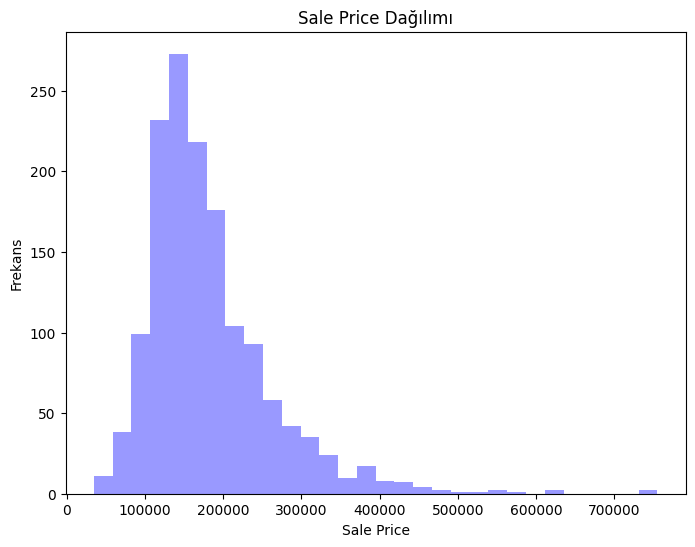

In [6]:
# 'SalePrice' sütununun dağılımını görselleştirme
plt.figure(figsize=(8, 6))
sns.distplot(training['SalePrice'], bins=30, kde=False, color='blue') # 'SalePrice' sütununu belirtilen renkte histogram olarak çizer

plt.title('Sale Price Dağılımı')
plt.xlabel('Sale Price')
plt.ylabel('Frekans')
plt.show()

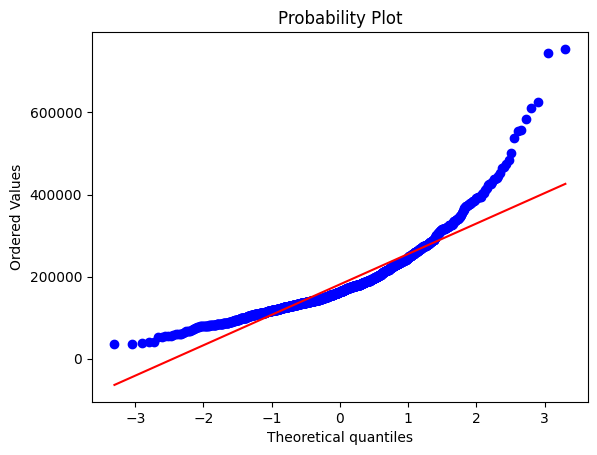

In [7]:

#Veri setinin normal dağılımına ne kadar uygun olduğunu göstermek için gerçek verilerin bir normal dağılım ile karşılaştırılmasını sağlayan bir olasılık plot'u oluşturuyoruz.
fig = plt.figure()
stats.probplot(training['SalePrice'], plot=plt)  
plt.show()

Grafik sağa çarpık bir görüntüde oluştu. Dağılımı normalleştireceğiz. Numpy kütüphanesinden np.log1p() fonksiyonu kullanıyorum. Sağa çarpık bir dağılımı normale yaklaştırabilir. 

In [8]:
training['SalePrice'] = np.log1p(training['SalePrice'])

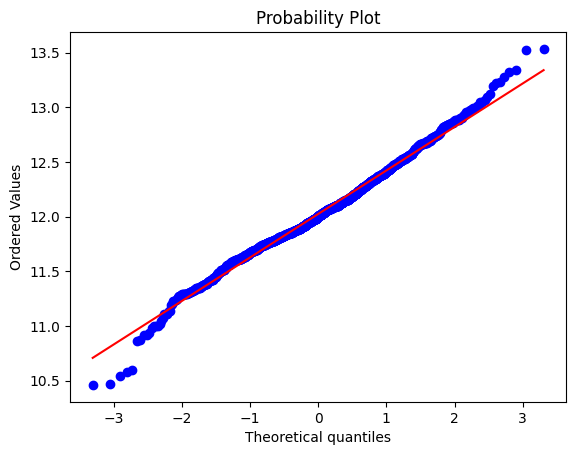

In [9]:
fig = plt.figure()
stats.probplot(training['SalePrice'], plot=plt)  
plt.show()

Dağılım daha normal bir hale geldi. Eksik veriler model eğitmek için problem oluşturur. Bu yüzden önce eksik olan değerleri görselleştirip ilgili sütunla arasındaki ilişkileri görselleştirip gerekli data cleaning işlemlerini yapmak gerekiyor.

In [10]:
#Eksik veriler ne kadar görmek istiyorum
training.columns[training.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [11]:
# Eksik verilerin grafiğini çizmek için:
#eksik değerlerin yüzdesini hesaplıyoruz
Isnull = training.isnull().sum() / len(training) * 100
Isnull = Isnull[Isnull > 0] #Sadece eksik değer olanları almak için
Isnull.sort_values(inplace = True, ascending = False) #Eksik değer yüzdesine göre 'Isnull' serisi içindeki sütunları azalan sırada sıralıyrouz
Isnull



PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

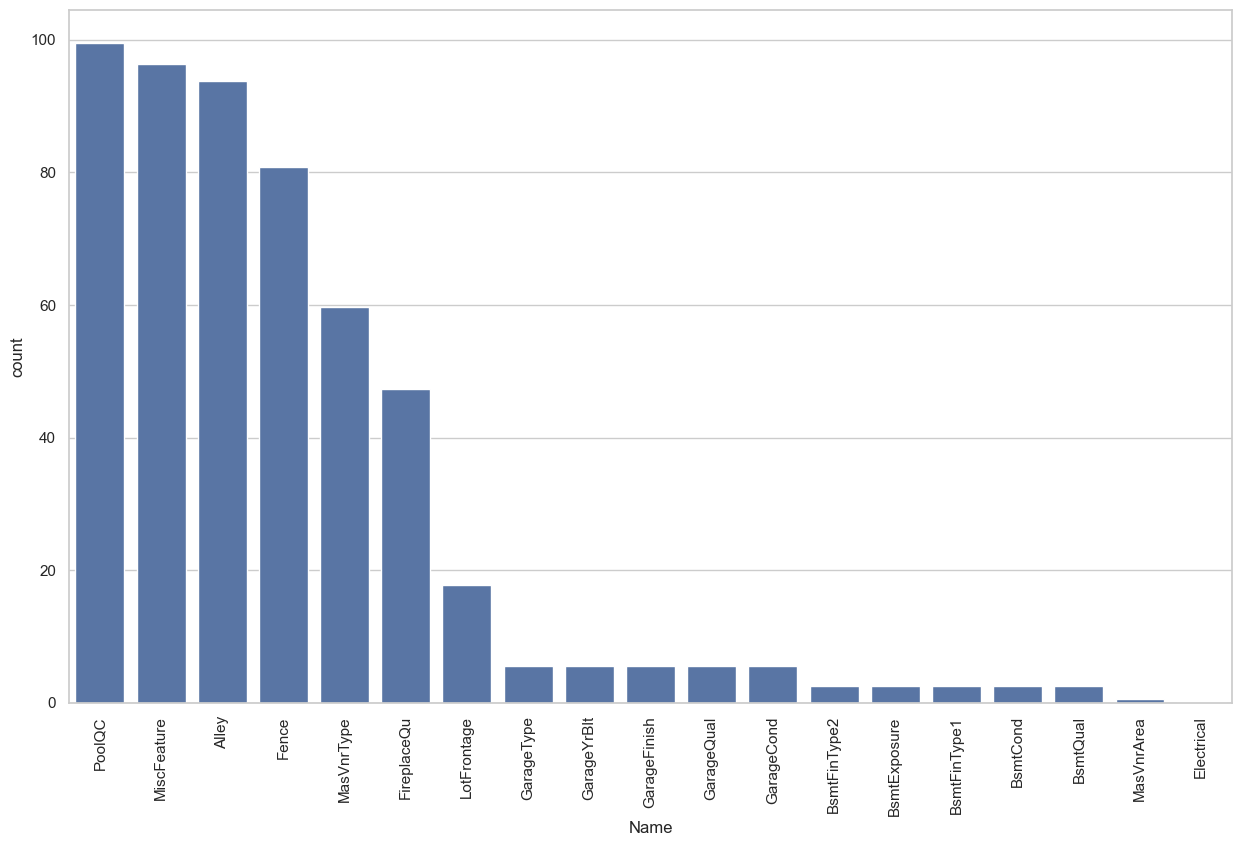

In [12]:
Isnull = Isnull.to_frame()
#Şimdi Her bir sütundaki değerlerin sayısını alalım
Isnull.columns = ['count']
Isnull.index.names = ['İsimler']
Isnull['Name'] = Isnull.index

plt.figure(figsize = (15, 9))
sns.set(style = 'whitegrid')
sns.barplot(x = 'Name', y = 'count', data = Isnull)
plt.xticks(rotation = 90)
plt.show()

In [13]:
#Sayısal değerlere sahip olan kısmını ayıklayacağım
traning_corr = training.select_dtypes(include = [np.number])

In [14]:
traning_corr.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,12.247699
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,12.109016
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,12.317171
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,11.849405
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,12.429220


<Axes: >

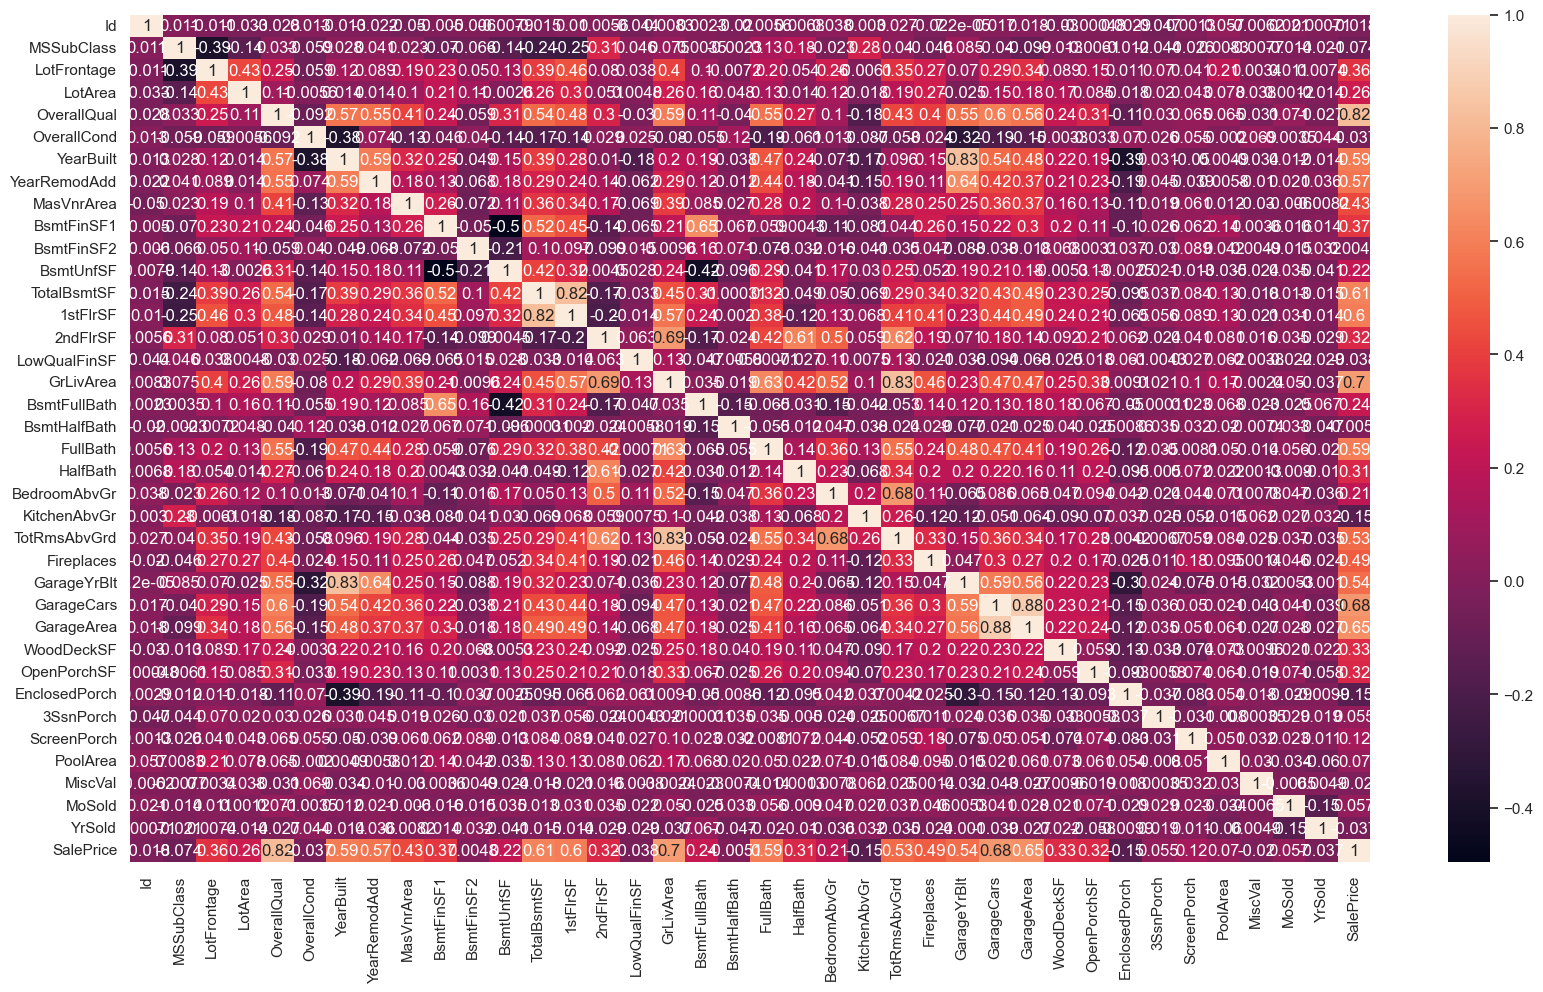

In [15]:
corr = traning_corr.corr()
plt.subplots(figsize = (20, 11))
sns.heatmap(corr, annot = True)

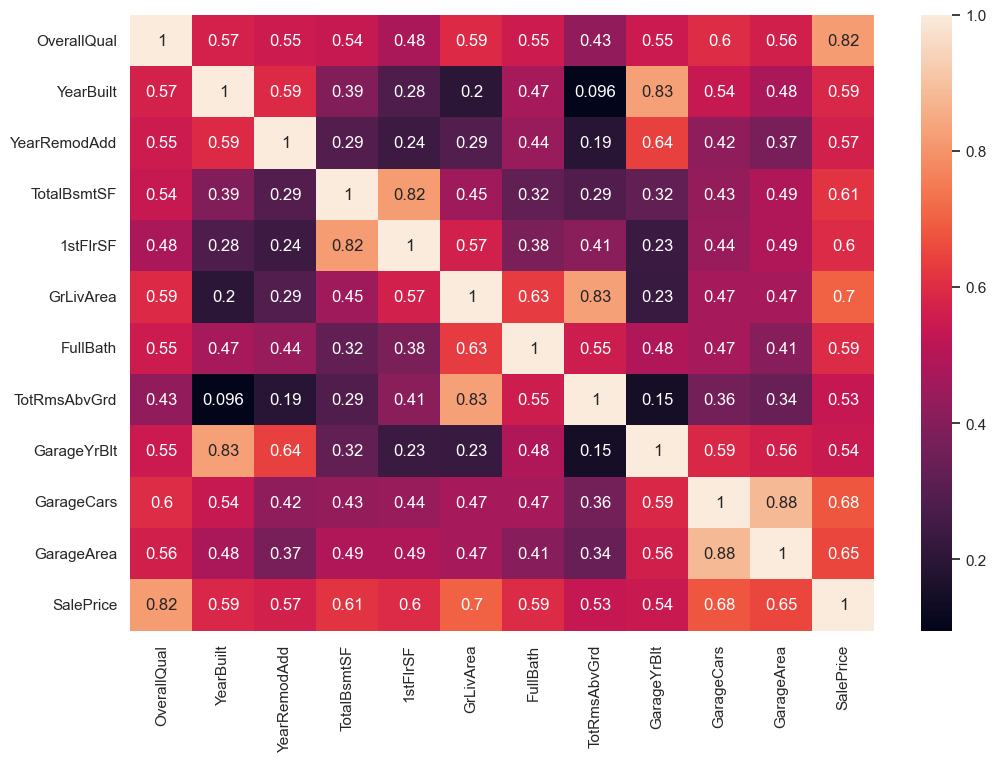

In [16]:
#Daha iyi görmek için en çok bilgi veren kısmı görselleştiyorum

eniyi_50_deger = corr.index[abs(corr['SalePrice'] > 0.5)]
plt.subplots(figsize = (12, 8))
eniyi_iliski = training[eniyi_50_deger].corr()
sns.heatmap(eniyi_iliski, annot = True)
plt.show()

SalesPrice sütunu ile en ilişkili olan özelliğin OverallQual olduğu heatmap'de görülüyor.

In [17]:
#Eşsiz değerleri inceliyorum
training.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

C:\Users\sevgi\AppData\Local\Temp\ipykernel_14740\3928771922.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='OverallQual', y='SalePrice', data=training, palette='viridis')


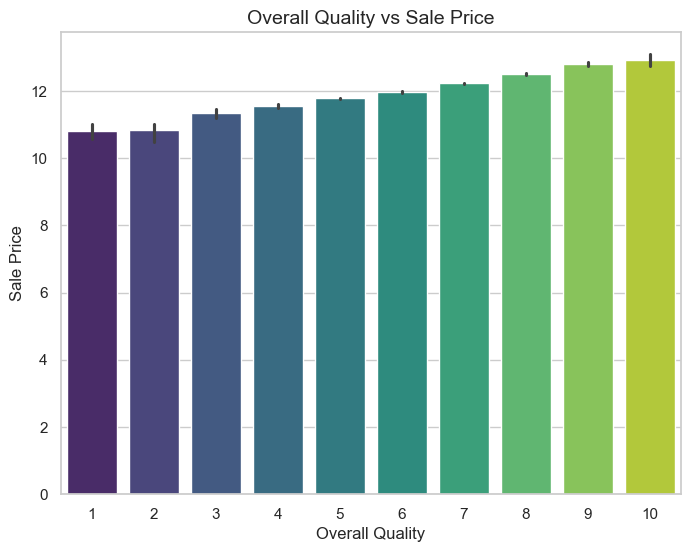

In [18]:
#OverallQual ile SalePrice ilişkisini görselleştitiyorum
plt.figure(figsize=(8, 6))
sns.barplot(x='OverallQual', y='SalePrice', data=training, palette='viridis')
plt.title('Overall Quality vs Sale Price', fontsize=14)
plt.xlabel('Overall Quality', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.show()

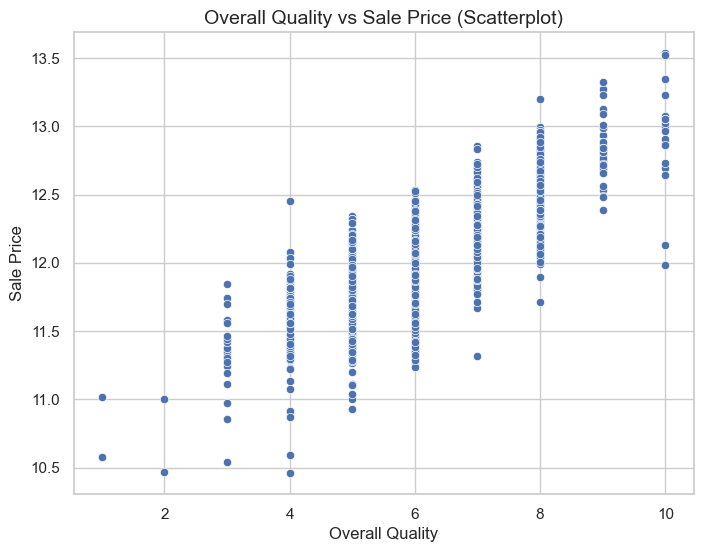

In [19]:
#Scatter plot grafiğinde de bakıyorum
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=training)
plt.title('Overall Quality vs Sale Price (Scatterplot)', fontsize=14)
plt.xlabel('Overall Quality', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.show()

c:\Users\sevgi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


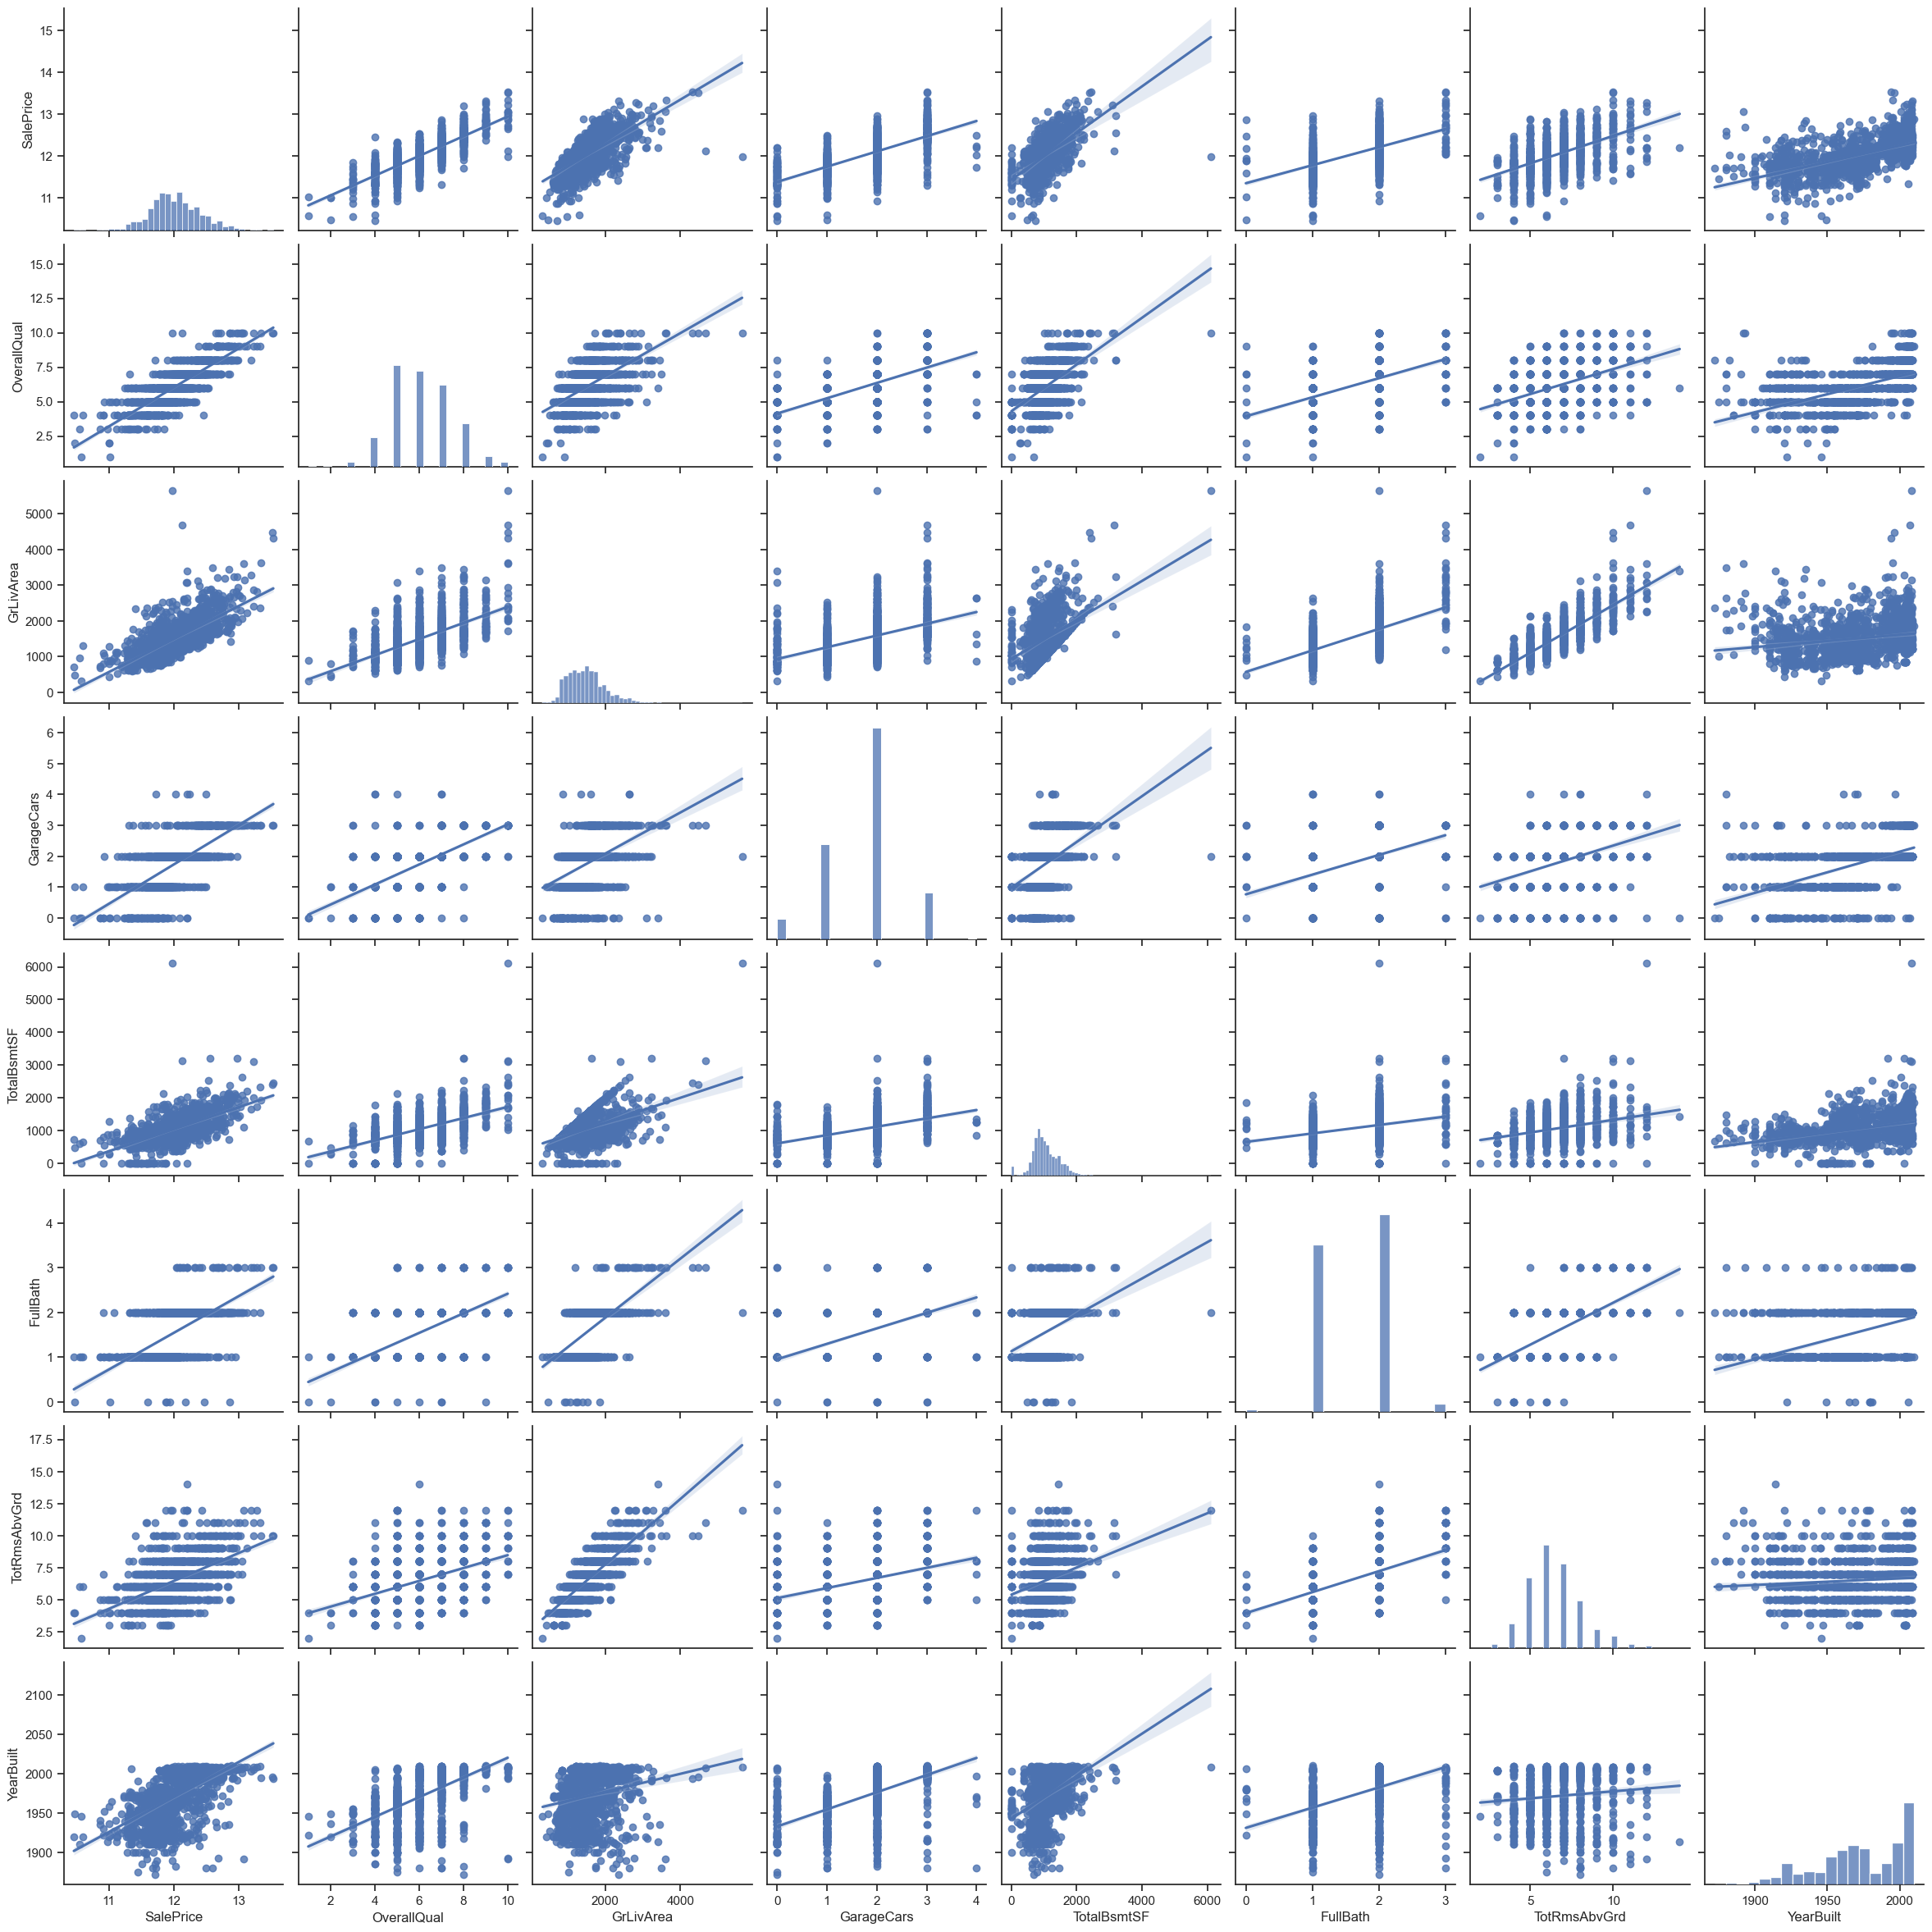

In [20]:
#Burada diğer değişkenlerin SalePrice ile arasında nasıl bir ilişki var aynı anda gözlemlemek istedim.
col = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
sns.set(style = 'ticks')
sns.pairplot(training[col], size = 3, kind = 'reg')

In [21]:
print('Hedef değişken(SalePrice) ile en iyi ilişkisi olan değişkeni bulalım')
corr = traning_corr.corr()
corr.sort_values(['SalePrice'], ascending = False, inplace = True)

corr.SalePrice

Hedef değişken(SalePrice) ile en iyi ilişkisi olan değişkeni bulalım


SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePr

In [22]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [23]:
#Eksik veriler için gerekli işlemleri yapıyorum
#İnfo kısmını inceleyip neredeyse hepsi boş değerlerden oluşan PoolQC None ile dolduruyorum.
training['PoolQC'] = training['PoolQC'].fillna('None')


In [24]:
#Diğer özellikler içinde % 50 eksik değer içierenleri None ile dolduruyoruz. Sonucu etkilemesinde az etkisi olması için yapıyoruz
#Bilgileri info'dan edindim.
training['MiscFeature'] = training['MiscFeature'].fillna('None') #54 non-null
training['Alley'] = training['Alley'].fillna('None') # 91 non-null  
training['Fence'] = training['Fence'].fillna('None') # 281 non-null
training['FireplaceQu'] = training['FireplaceQu'].fillna('None') # 770 non-null

In [25]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [26]:
# Gruplama işlemi yapıyoruz. 
training['LotFrontage'] = training.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [27]:
training['GarageArea']

0       548
1       460
2       608
3       642
4       836
       ... 
1455    460
1456    500
1457    252
1458    240
1459    276
Name: GarageArea, Length: 1460, dtype: int64

Bu doldurma işlemleri, eksik değerlerin veri setinde daha uygun bir şekilde temsil edilmesini sağlar ve bazı durumlarda eksik verilerin modelleme sürecinde daha iyi ele alınmasına yardımcı olabilir. 

In [28]:
#GarageType, GarageFinish, GarageQual ve GarageCond bunlarıda none ile değiştirelim
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    training[col] = training[col].fillna('None')

In [29]:
#Garaj ile ilgili sayısal olan değerleri de 0 ile değiştiriyorum 
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    training[col] = training[col].fillna(int(0))

In [30]:
#BsmtFinType2, BsmtExposure, BsmtFinType1, BsmtCond, BsmtQual None ile değiştirelim
for col in ('BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual'):
    training[col] = training[col].fillna('None')

In [31]:
training['MasVnrArea']

0       196.0
1         0.0
2       162.0
3         0.0
4       350.0
        ...  
1455      0.0
1456    119.0
1457      0.0
1458      0.0
1459      0.0
Name: MasVnrArea, Length: 1460, dtype: float64

In [32]:
training['MasVnrArea'] = training['MasVnrArea'].fillna(int(0))


In [33]:
training['MasVnrType'] = training['MasVnrType'].fillna('None')


In [34]:
#En çok tekrar eden değer kullanarak doldurduk
training['Electrical'] = training['Electrical'].fillna(training['Electrical']).mode()[0]


In [35]:
#Bu değere ihtiyacımız yok o yüzden siliyorum
training = training.drop(['Utilities'], axis =1)


<Axes: >

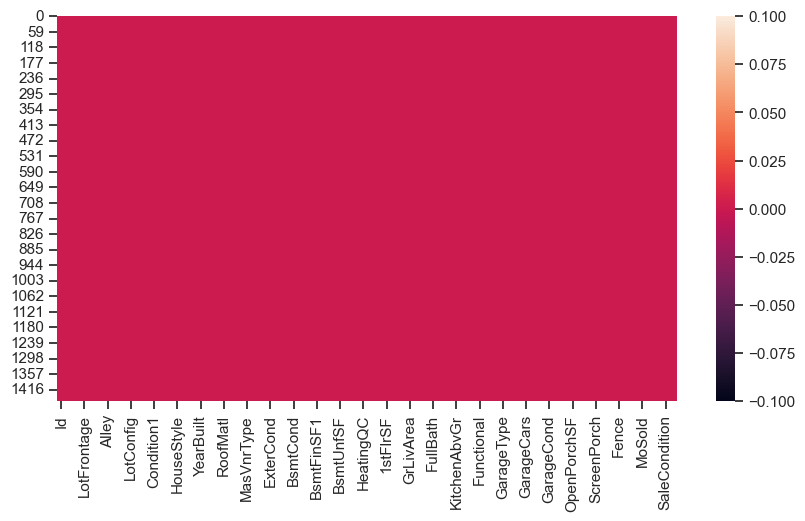

In [36]:
plt.figure(figsize =(10, 5))
sns.heatmap(training.isnull())

Null değerimiz olmadığına göre sklearn.preprocessing kütüphanesinden LabelEncoder sınıfını kullanarak kategorik olan verileri sayısal değerlere dönüştüreceğim.

In [37]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
        'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'GarageType', 'MiscFeature', 
        'SaleType', 'SaleCondition', 'Electrical', 'Heating')

In [38]:
from sklearn.preprocessing import LabelEncoder
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(training[c].values))
    training[c] = lbl.transform(list(training[c].values))

In [39]:
#SalePrice verileri tahmin edeceğimiz için ilgili sütunu sildim. Öncesinde yeni bir değişkene atıyorum.
y = training['SalePrice']


In [40]:
del training['SalePrice']

x_train: Makine öğrenimi modelinin eğitilmesi için kullanılan bağımsız değişkenlerin (features veya özelliklerin) bulunduğu eğitim veri setinin parçasıdır. Bu veri seti, modelin öğrenme sürecinde kullanılan verileri içerir.

y_train: x_train'deki bağımsız değişkenlere karşılık gelen hedef değişkenin (target veya label) değerlerinin bulunduğu eğitim veri setinin hedef kısmıdır. Bu, modelin eğitilirken öğrenmeye çalıştığı değerleri içerir.

x_test: Makine öğrenimi modelinin eğitildikten sonra performansını değerlendirmek için kullanılan bağımsız değişkenlerin bulunduğu test veri setinin parçasıdır. Bu veri seti, eğitim veri setinden farklı, ancak benzer özelliklere sahip veriler içerir.

y_test: x_test'teki bağımsız değişkenlere karşılık gelen gerçek hedef değişkenin değerlerinin bulunduğu test veri setinin hedef kısmıdır. Bu, modelin eğitildikten sonra gerçek veriler üzerinde ne kadar iyi performans gösterdiğini değerlendirmek için kullanılır.

In [41]:
#Model için x ve y değerleri belirliyorum
X = training.values
y = y.values


In [42]:
#Verileri eğitim ve test verileri olmak üzere ikiye ayıralım (%80 eğitim % 20 test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

Lineer Regresyon

In [43]:
# Model oluşturma
from sklearn import linear_model
model = linear_model.LinearRegression()

In [44]:
# Oluşturulan model fit() fonksiyonu ile eğitim veri seti üzerinde eğitiliyor
model.fit(X_train, y_train)

LinearRegression()

In [45]:
#Şimdi de eğittiğimiz modelimiz üzerinden tahminler yapalım
print("Tahmin edilen değer : " + str(model.predict([X_test[100]])))
print("Gerçek değer : " + str(y_test[100]))

Tahmin edilen değer : [11.62221633]
Gerçek değer : 11.767187766223199


In [46]:
print("Doğruluk oranı :  ", model.score(X_test, y_test)* 100)

Doğruluk oranı :   89.26708677161413


In [47]:
from sklearn.metrics import mean_squared_error

# model.predict ile tahminleri yapmak için:
predictions = model.predict(X_test)

# MSE hesaplamak için:
mse = mean_squared_error(y_test, predictions)
print("Ortalama Kare Hatası (MSE):", mse)

Ortalama Kare Hatası (MSE): 0.017985248370132836


In [48]:
from sklearn.metrics import explained_variance_score

# predictions: modelin yaptığı tahminler
# y_test: gerçek hedef değerler
variance_score = explained_variance_score(y_test, predictions)
print("Varyans Skoru:", variance_score)


Varyans Skoru: 0.8926914471311487


Random Forest Regression

In [49]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 1000)

In [50]:
#modeli eğitmek için:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [51]:
#Modelin doğruluğunu kontrol etmek için: 
print("Doğruluk oranı :", model.score(X_test, y_test)*100)

Doğruluk oranı : 89.4554721391843


In [52]:
from sklearn.metrics import mean_squared_error

# model.predict ile tahminleri yapmak için:
predictions = model.predict(X_test)

# MSE hesaplamak için:
mse = mean_squared_error(y_test, predictions)
print("Ortalama Kare Hatası (MSE):", mse)

Ortalama Kare Hatası (MSE): 0.017669569154904738


In [53]:
from sklearn.metrics import explained_variance_score

# predictions: modelin yaptığı tahminler
# y_test: gerçek hedef değerler
variance_score = explained_variance_score(y_test, predictions)
print("Varyans Skoru:", variance_score)


Varyans Skoru: 0.8945553873453398
